Download events (/events/) & matches (/matches/) & players (./players.json) from https://figshare.com/collections/Soccer_match_event_dataset/4415000/3

In [1]:
import pandas as pd
import numpy as np
from collections import ChainMap
competition = 'France'
events = pd.read_json('events/events_{}.json'.format(competition)).set_index('id')
matches = pd.read_json('matches/matches_{}.json'.format(competition)).set_index('wyId')
players = pd.read_json('players.json').set_index('wyId')

# Matches 

In [ ]:
def filter_last_minutes_events(events, matchId, minutes=10):
    return events[(events['matchId']==matchId) & (events['matchPeriod']=='2H') & (events['eventSec']>(45-minutes)*60)]

In [ ]:
minutes = 10

# Classification

In [2]:
def get_goals_per_game(teamsData):
    keys_team_data = list(teamsData.keys())
    return {keys_team_data[0]:teamsData[keys_team_data[0]]['score'],keys_team_data[1]:teamsData[keys_team_data[1]]['score']}

In [3]:
def get_points_per_score(teamsData): #{'3783': 2, '3767': 1}    
    keys_team_data = list(teamsData.keys())    
    score_match = get_goals_per_game(teamsData)
    if score_match[keys_team_data[0]]==score_match[keys_team_data[1]]:
        return {keys_team_data[0]:1,keys_team_data[1]:1}
    if score_match[keys_team_data[0]]>score_match[keys_team_data[1]]:
        return {keys_team_data[0]:3,keys_team_data[1]:0}
    if score_match[keys_team_data[0]]<score_match[keys_team_data[1]]:
        return {keys_team_data[0]:0,keys_team_data[1]:3}

In [9]:
def get_points_round(round_matches):
    matches_selected = round_matches.sort_values('gameweek')
    dicts = matches_selected.apply(lambda x: get_points_per_score(x['teamsData']), axis=1)
    return dict(ChainMap(*list(dicts)))

In [15]:
def get_points_league(matches):
    all_rounds = {}
    for gameweek, matches_played in matches.groupby('gameweek'):
        all_rounds[gameweek]=get_points_round(matches_played)
    return pd.DataFrame.from_dict(all_rounds)

In [ ]:
# points = get_points_league(matches)

In [16]:
def get_points_aggregated_by_round(matches):
    points = get_points_league(matches)
    for round_i in range(2,len(points.columns)+1):
        points[round_i]=points[[round_i-1,round_i]].sum(axis=1)
    return points

In [ ]:
# points_agg = get_points_aggregated_by_round(matches)

In [19]:
def get_classification_by_round(matches):
    points_agg = get_points_aggregated_by_round(matches)
    return points_agg.rank(method='first',ascending=False).astype(int)

In [20]:
#classification = get_classification_by_round(matches)

In [103]:
def get_frequency_of_position_changes(matches):
    classification = get_classification_by_round(matches)
    all_ranks = [rank for team in classification.values
         for rank in [rank for i, rank in enumerate(team) 
            if i==0 or team[i-1]!=rank]]
    unique, counts = np.unique(all_ranks, return_counts=True)
    return pd.Series(dict(zip(unique, counts)))

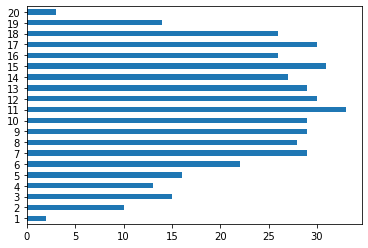

In [110]:
import matplotlib.pyplot
get_frequency_of_position_changes(matches).plot.barh()

In [71]:
# win / month